# Feature performance comparison

The purpose of this notebook is to compare the classification performance of the individual features, and their combination, for E. Coli

# Imports

In [1]:
# from sklearnex import patch_sklearn
# patch_sklearn()

import os
import sys
from IPython.display import display

sys.path.append('../src')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.base import clone

import matplotlib.pyplot as plt

from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import Rank1D, Rank2D

import pandas as pd
import numpy as np
import seaborn as sns

from dataset.transporter_dataset import create_dataset
from dataset.cluster_fasta import cd_hit
from features.labels import fasta_to_labels
from features.compositions import calculate_composition_feature
from features.pssm import calculate_pssm_feature
from features.coexp import calculate_coexp_feature
from models.eval import nested_crossval
from visualization.feature_plots import create_plot

# Globals

In [2]:
N_THREADS = 16
IDENTITY_THRESHOLD=70
TAX_ID = 559292
ORGANISM = "yeast"
LOG_FILE = f"../logs/{ORGANISM}_amino_sugar.log"

# Dataset

In [3]:
# Delete previous log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, "w"):
        pass

create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Membrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    verbose=True,
    tax_ids_filter=[TAX_ID],
    output_tsv=f"../data/datasets/{ORGANISM}_amino_sugar.tsv",
    output_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_log=LOG_FILE,
)


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
Q08986,Amino-acid transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,SAM3 YPL274W,S-adenosylmethionine permease SAM3 (S-adenosyl...,2.A.3.10.15,559292,MDILKRGNESDKFTKIETESTTIPNDSDRSGSLIRRMKDSFKQSNL...
P38967,Amino-acid transport,Membrane;Transmembrane,Transport,TAT2 LTG3 SAB2 SCM2 TAP2 YOL020W,Tryptophan permease (Tryptophan amino acid tra...,2.A.3.10.8,559292,MTEDFISSVKRSNEELKERKSNFGFVEYKSKQLTSSSSHNSNSSHH...
P39003,Sugar transport,Membrane;Transmembrane,Transport,HXT6 YDR343C D9651.12,High-affinity hexose transporter HXT6,NaN,559292,MSQDAAIAEQTPVEHLSAVDSASHSVLSTPSNKAERDEIKAYGEGE...
P38085,Amino-acid transport,Membrane;Transmembrane,Transport,TAT1 TAP1 VAP1 YBR069C YBR0710,Valine/tyrosine/tryptophan amino-acid permease...,2.A.3.10.9,559292,MDDSVSFIAKEASPAQYSHSLHERTHSEKQKRDFTITEKQDEVSGQ...
...,...,...,...,...,...,...,...,...
P40004,Sugar transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,YEA4 YEL004W,UDP-N-acetylglucosamine transporter YEA4,2.A.7.10.5,559292,MWNSLKAFALVFGGCCSNVITFETLMSNETGSINNLITFCQFLFVT...
Q06328,Amino-acid transport,Membrane;Transmembrane,Transport,YPQ2 YDR352W,Probable vacuolar amino acid transporter YPQ2 ...,2.A.43.2.8,559292,MSCSNGIWPTVSNLCGSLSFFTSVISLFPQIIETYRDKSVDGLSPY...
Q12235,Amino-acid transport,Cell membrane;Endoplasmic reticulum;Membrane;T...,Transport,YCT1 YLL055W L0578,High affinity cysteine transporter,2.A.1.14.20,559292,MSKVDVKIGADSISSSDEILVPSRLADVTLAFMEENDAAVPEITPE...


## Clustering

In [4]:
cd_hit(
    executable_location="cd-hit",
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    log_file=LOG_FILE,
    identity_threshold=IDENTITY_THRESHOLD,
    n_threads=N_THREADS,
    memory=4096,
    verbose=True,
)

## Annotations

In [5]:
df_annotations = pd.read_table(f"../data/datasets/{ORGANISM}_amino_sugar.tsv", index_col=0)
df_annotations.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
Q08986,Amino-acid transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,SAM3 YPL274W,S-adenosylmethionine permease SAM3 (S-adenosyl...,2.A.3.10.15,559292,MDILKRGNESDKFTKIETESTTIPNDSDRSGSLIRRMKDSFKQSNL...
P38967,Amino-acid transport,Membrane;Transmembrane,Transport,TAT2 LTG3 SAB2 SCM2 TAP2 YOL020W,Tryptophan permease (Tryptophan amino acid tra...,2.A.3.10.8,559292,MTEDFISSVKRSNEELKERKSNFGFVEYKSKQLTSSSSHNSNSSHH...
P39003,Sugar transport,Membrane;Transmembrane,Transport,HXT6 YDR343C D9651.12,High-affinity hexose transporter HXT6,NaN,559292,MSQDAAIAEQTPVEHLSAVDSASHSVLSTPSNKAERDEIKAYGEGE...
P38085,Amino-acid transport,Membrane;Transmembrane,Transport,TAT1 TAP1 VAP1 YBR069C YBR0710,Valine/tyrosine/tryptophan amino-acid permease...,2.A.3.10.9,559292,MDDSVSFIAKEASPAQYSHSLHERTHSEKQKRDFTITEKQDEVSGQ...


# Feature generation

## Labels

In [6]:
fasta_to_labels(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
)
df_labels = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
    index_col=0,
)
df_labels.labels.value_counts()

Amino-acid transport    34
Sugar transport         17
Name: labels, dtype: int64

## AAC

In [7]:
calculate_composition_feature(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_aac.tsv",
    feature_type="aac",
)

## Reading dataframes

In [8]:
df_aac = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_aac.tsv",
    index_col=0,
)

# Functions

In [9]:
def get_feature_stats(df_features, df_labels_, labels=["Amino-acid transport", "Sugar transport"]):
    df_stats = pd.concat(
        {
            "corr": df_features.corrwith(
                df_labels_.labels.transform(lambda x: 1.0 if x == labels[1] else 0.0)
            ),
            "mean": df_features.mean(),
            "std": df_features.std(),
        },
        axis=1,
    )

    df_stats["corr_abs"] = df_stats["corr"].abs()

    df_stats["mean0"] = df_features.loc[df_labels_[df_labels_.labels == labels[0]].index].mean()
    df_stats["mean1"] = df_features.loc[df_labels_[df_labels_.labels == labels[1]].index].mean()

    df_stats["median0"] = df_features.loc[
        df_labels_[df_labels_.labels == labels[0]].index
    ].median()
    df_stats["median1"] = df_features.loc[
        df_labels_[df_labels_.labels == labels[1]].index
    ].median()

    df_stats["mediandiff"] = (df_stats["median0"] - df_stats["median1"]).abs()
    df_stats = df_stats.sort_values("mediandiff", ascending=False)
    return df_stats

In [10]:
def get_independent_test_set(
    df_features, df_labels_, labels=["Amino-acid transport", "Sugar transport"], test_size=0.2
):
    X = df_features.to_numpy()
    y = np.where(df_labels_.labels == labels[1], 1, 0)
    feature_names = df_features.columns.to_numpy()
    sample_names = df_features.index.to_numpy()
    (
        X_train,
        X_test,
        y_train,
        y_test,
        sample_names_train,
        sample_names_test,
    ) = train_test_split(
        X, y, sample_names, stratify=y, random_state=42, shuffle=True, test_size=test_size
    )
    return (
        X_train,
        X_test,
        y_train,
        y_test,
        sample_names_train,
        sample_names_test,
        feature_names,
    )


In [11]:
def print_validation_results(y_true_, y_pred_, labels = ["Amino", "Sugar"]):
    report_dict = classification_report(y_true=y_true_, y_pred=y_pred_, output_dict=True)
    report_dict = {
        labels[0]: report_dict['0'],
        labels[1]: report_dict['1'],
        "Macro": report_dict["macro avg"],
        "Weighted": report_dict["weighted avg"]
    }
    report_df = pd.DataFrame.from_dict(report_dict)
    confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true_, y_pred_),
        columns=labels,
        index=labels,
    )
    return report_df, confusion_matrix_df

# Individual Features

## AAC

### Stats, Plots

In [12]:
get_feature_stats(df_aac, df_labels)

,corr,mean,std,corr_abs,mean0,mean1,median0,median1,mediandiff
T,0.444554,0.055479,0.011697,0.444554,0.051839,0.062761,0.049279,0.063269,0.013990
I,-0.205984,0.086442,0.013778,0.205984,0.088429,0.082468,0.087737,0.075838,0.011899
A,-0.252023,0.070476,0.015988,0.252023,0.073297,0.064833,0.074679,0.065026,0.009652
L,-0.162072,0.106267,0.022127,0.162072,0.108777,0.101245,0.107594,0.100000,0.007594
Y,0.246269,0.037607,0.009119,0.246269,0.036034,0.040751,0.034996,0.042125,0.007129
S,-0.115735,0.088771,0.014838,0.115735,0.089973,0.086366,0.089145,0.082770,0.006375
M,0.381225,0.025090,0.007613,0.381225,0.023058,0.029154,0.023457,0.029316,0.005859
G,-0.030011,0.074451,0.013021,0.030011,0.074725,0.073904,0.074138,0.079545,0.005407
P,-0.391528,0.037922,0.007760,0.391528,0.040049,0.033668,0.041124,0.036199,0.004925
N,0.151640,0.045540,0.010525,0.151640,0.044423,0.047775,0.042831,0.047452,0.004621


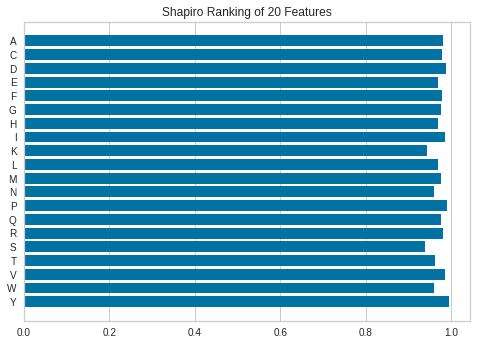

In [13]:
from yellowbrick.features import rank1d
rank1d(df_aac.to_numpy(), np.where(df_labels.labels == "Sugar transport", 1, 0), features = df_aac.columns)
plt.show()

### Independent test set

In [14]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    sample_names_train,
    sample_names_test,
    feature_names,
) = get_independent_test_set(df_aac, df_labels, test_size=0.2)

### Preprocessing

In [15]:
# preprocess = make_pipeline(StandardScaler())
# X_train_processed = preprocess.fit_transform(X_train)

### Model selection

SVC (with default RBF kernel) and linear SVM look the most promising. I will choose RBF and switch to linear if the model is overfitting.

In [16]:
for estimator in [
    LinearSVC(random_state=0),
    LinearSVC(class_weight="balanced", random_state=0),
    SVC(),
    SVC(class_weight="balanced"),
    GaussianNB(),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=0),
    RandomForestClassifier(class_weight="balanced", random_state=0),
    SGDClassifier(random_state=0),
]:
    pipeline = make_pipeline(StandardScaler(), estimator)
    scores = cross_val_score(estimator, X_train, y_train, scoring="f1_macro")
    print("### ", estimator)
    print(f"CV folds: {scores.round(3)}")
    print(f"Mean: {scores.mean().round(3)}")
    print(f"Std: {scores.std().round(3)}")


###  LinearSVC()
CV folds: [0.429 0.429 0.385 0.385 0.385]
Mean: 0.402
Std: 0.022
###  LinearSVC(class_weight='balanced')
CV folds: [0.619 0.564 0.75  0.385 0.733]
Mean: 0.61
Std: 0.133
###  SVC()
CV folds: [0.429 0.429 0.385 0.385 0.385]
Mean: 0.402
Std: 0.022
###  SVC(class_weight='balanced')
CV folds: [0.619 0.564 0.75  0.385 0.733]
Mean: 0.61
Std: 0.133
###  GaussianNB()
CV folds: [0.667 0.564 1.    0.385 0.564]
Mean: 0.636
Std: 0.204
###  KNeighborsClassifier()
CV folds: [0.795 0.795 0.564 0.385 0.385]
Mean: 0.585
Std: 0.184
###  RandomForestClassifier()
CV folds: [0.795 0.667 0.855 0.385 0.385]
Mean: 0.617
Std: 0.199
###  RandomForestClassifier(class_weight='balanced')
CV folds: [0.795 0.667 0.855 0.385 0.385]
Mean: 0.617
Std: 0.199
###  SGDClassifier()
CV folds: [0.429 0.429 0.273 0.385 0.385]
Mean: 0.38
Std: 0.057


### Parameter tuning

In [17]:
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), SVC()),
    param_grid={
        "svc__class_weight": ["balanced", None],
        "svc__C": [0.1, 1, 10],
        "svc__gamma": [1e-0, 1e-1, 1e-2],
    },
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_)
print(gsearch.best_score_)
best_estimator_svc = gsearch.best_estimator_


{'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 0.1}
0.7401398601398601


### Dimensionality reduction

In [18]:
df_train = pd.DataFrame(X_train, columns=feature_names, index=sample_names_train)
get_feature_stats(df_train, df_labels.loc[df_train.index])

,corr,mean,std,corr_abs,mean0,mean1,median0,median1,mediandiff
L,-0.276902,0.105908,0.022961,0.276902,0.110264,0.096861,0.109827,0.093146,0.016681
I,-0.157943,0.087297,0.014833,0.157943,0.088902,0.083963,0.087755,0.075838,0.011917
T,0.349646,0.055798,0.012041,0.349646,0.052914,0.061789,0.050736,0.062500,0.011764
A,-0.189678,0.070957,0.015530,0.189678,0.072975,0.066765,0.078035,0.068783,0.009252
E,0.353451,0.042059,0.009215,0.353451,0.039827,0.046694,0.039755,0.047511,0.007756
S,-0.168578,0.089530,0.014999,0.168578,0.091263,0.085932,0.090312,0.082601,0.007711
Y,0.357016,0.036493,0.008450,0.357016,0.034426,0.040786,0.034694,0.042125,0.007431
G,0.078984,0.074675,0.013146,0.078984,0.073963,0.076153,0.073469,0.079630,0.006160
M,0.360829,0.024659,0.006311,0.360829,0.023099,0.027900,0.023217,0.029221,0.006004
P,-0.357256,0.038731,0.007947,0.357256,0.040676,0.034691,0.041431,0.036630,0.004801


In [19]:
params_svc = {
    "svc__class_weight": ["balanced"],
    "svc__C": [1, 10, 100],
    "svc__gamma": ["scale", 1e-1, 1e-2, 1e-3],
    "selectkbest__k": list(range(1, 20)),
}
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), SelectKBest(), SVC()),
    param_grid=params_svc,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
    refit=True,
)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_)
print(gsearch.best_score_.round(3))
print(
    "Removed features ",
    feature_names[~gsearch.best_estimator_["selectkbest"].get_support()],
)
best_estimator_svc_kbest = gsearch.best_estimator_


{'selectkbest__k': 10, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.769
Removed features  ['C' 'D' 'F' 'G' 'K' 'N' 'Q' 'R' 'V' 'W']


In [20]:
params_svc = {
    "svc__class_weight": ["balanced", None],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", 1, 1e-1, 1e-2],
    "pca__n_components": np.linspace(0.8, 0.99, 20),
}
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), PCA(), SVC()),
    param_grid=params_svc,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
    refit=True,
)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_)
print(gsearch.best_score_)
best_estimator_svc_pca = gsearch.best_estimator_
display(
    pd.DataFrame.from_records(
        [
            feature_names,
            gsearch.best_estimator_["pca"].components_[0],
            gsearch.best_estimator_["pca"].components_[1],
            gsearch.best_estimator_["pca"].components_[2],
        ],
        index=["Feature", "Contrib. PC1", "Contrib. PC2", "Contrib. PC3"],
    )
    .T.set_index("Feature")
    .sort_values("Contrib. PC1", ascending=False)
)

pca = PCA()
pca.fit(X_train)
csum = np.cumsum(pca.explained_variance_ratio_)
print("Number of components to explain variance:", np.argmax(csum >= 0.93) + 1)


{'pca__n_components': 0.89, 'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.1}
0.8187412587412588


,Contrib. PC1,Contrib. PC2,Contrib. PC3
Feature,,,
W,0.421599,-0.056381,0.01399
G,0.355673,0.223982,-0.003557
E,0.228843,-0.025155,0.49746
V,0.203374,0.158521,-0.289411
A,0.200623,0.301214,0.14963
Y,0.195044,-0.295328,0.277625
C,0.193219,-0.039891,-0.024669
K,0.189438,0.024967,-0.108831
F,0.167663,-0.321156,-0.238997


Number of components to explain variance: 11


### Validation

In [21]:
best_estimator = best_estimator_svc_kbest
best_scores = cross_val_score(
    estimator=clone(best_estimator), X=X_train, y=y_train, scoring="f1_macro"
)
print(f"Train scores: {best_scores.mean().round(3)}+-{best_scores.std().round(3)}")

y_pred = best_estimator.predict(X_test)
y_true = y_test.copy()

report_df, confusion_matrix_df = print_validation_results(y_true, y_pred, labels=["Amino", "Sugar"])
display(report_df.round(3))
display(confusion_matrix_df)

Train scores: 0.769+-0.23


,Amino,Sugar,Macro,Weighted
precision,0.750,0.667,0.708,0.720
recall,0.857,0.500,0.679,0.727
f1-score,0.800,0.571,0.686,0.717
support,7.000,4.000,11.000,11.000


,Amino,Sugar
Amino,6,1
Sugar,2,2


In [22]:
best_estimator = best_estimator_svc_pca
best_scores = cross_val_score(
    estimator=clone(best_estimator), X=X_train, y=y_train, scoring="f1_macro"
)
print(f"Train scores: {best_scores.mean().round(3)}+-{best_scores.std().round(3)}")

y_pred = best_estimator.predict(X_test)
y_true = y_test.copy()

report_df, confusion_matrix_df = print_validation_results(y_true, y_pred, labels=["Amino", "Sugar"])
display(report_df.round(3))
display(confusion_matrix_df)

Train scores: 0.819+-0.227


,Amino,Sugar,Macro,Weighted
precision,0.750,0.667,0.708,0.720
recall,0.857,0.500,0.679,0.727
f1-score,0.800,0.571,0.686,0.717
support,7.000,4.000,11.000,11.000


,Amino,Sugar
Amino,6,1
Sugar,2,2


# Alternative Evaluation

In [23]:
from sklearn.model_selection import LeaveOneOut

X = df_aac.values
labels = df_labels.labels
y = np.where(labels == "Sugar transport", 1, 0)


params_svc = {
    "svc__class_weight": ["balanced"],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", 1e-1, 1e-2, 1e-3],
}
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), SVC()),
    param_grid=params_svc,
    cv=LeaveOneOut(),
    scoring="f1_macro",
    # n_jobs=1,
    return_train_score=True,
    refit=True,
)
# the score does not make a difference, since it's either 1 (correct) or 0 (incorrect)
res = cross_val_predict(gsearch, X, y, n_jobs=-1, cv=LeaveOneOut())
print(f1_score(y, res, average="macro"))


params_svc = {
    "svc__class_weight": ["balanced"],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", 1e-1, 1e-2, 1e-3],
    "pca__n_components": [0.8, 0.9],
}
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), PCA(), StandardScaler(), SVC()),
    param_grid=params_svc,
    cv=LeaveOneOut(),
    scoring="f1_macro",
    # n_jobs=1,
    return_train_score=True,
    refit=True,
)
# the score does not make a difference, since it's either 1 (correct) or 0 (incorrect)
res = cross_val_predict(gsearch, X, y, n_jobs=-1, cv=LeaveOneOut())
print(f1_score(y, res, average="macro"))


0.722962962962963
0.7733333333333334
